# Download and extract video

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install pytube

In [0]:
import cv2
from pytube import YouTube
from pathlib import Path

In [2]:
%cd drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook

/content/drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/notebook


https://www.youtube.com/watch?v=MLDwPH5qBtY

In [0]:
save_dir = Path('../data/source/')
save_dir.mkdir(exist_ok=True)

img_dir = save_dir.joinpath('images')
img_dir.mkdir(exist_ok=True)

In [0]:
# Bruno Mars - That's What I Like
yt = YouTube('https://www.youtube.com/watch?v=MLDwPH5qBtY')
yt.streams.first().download(save_dir, 'mv')

NameError: ignored

In [0]:
cap = cv2.VideoCapture(str(save_dir.joinpath('mv (2).mp4')))
i = 0
while(cap.isOpened()):
    flag, frame = cap.read()
    if flag == False or i == 1000:
        break
    cv2.imwrite(str(img_dir.joinpath(f'img_{i:04d}.png')), frame)
    i += 1

content/drive/My Drive/Colab Notebooks/EDN/pytorch-EverybodyDanceNow-master/data/source/mv (1).mp4

# Pose estimation (OpenPose)

In [4]:
!pip3 install torch torchvision

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

%matplotlib inline

In [0]:
openpose_dir = Path('../src/pytorch_Realtime_Multi-Person_Pose_Estimation/')

import sys
sys.path.append(str(openpose_dir))
sys.path.append('../src/utils')

%reload_ext autoreload
%autoreload 2

In [7]:
!pip install cython pycocotools tensorboardX torch-encoding

In [0]:
# openpose
from network.rtpose_vgg import get_model
from evaluate.coco_eval import get_multiplier, get_outputs

# utils
from openpose_utils import remove_noise, get_pose

In [9]:
import torch
torch.cuda.is_available()

True

In [10]:
weight_name = openpose_dir.joinpath('pose_model.pth')
model = get_model('vgg19')     
model.load_state_dict(torch.load(weight_name))
model = torch.nn.DataParallel(model).cuda()
model.float()
model.eval()
pass

Bulding VGG19


## check

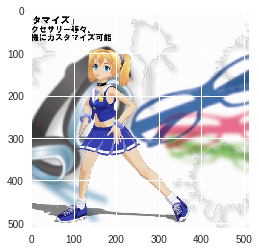

In [11]:
img_path = sorted(img_dir.iterdir())[137]
img = cv2.imread(str(img_path))
shape_dst = np.min(img.shape[:2])
# offset
oh = (img.shape[0] - shape_dst) // 2
ow = (img.shape[1] - shape_dst) // 2

img = img[oh:oh+shape_dst, ow:ow+shape_dst]
img = cv2.resize(img, (512, 512))
          
plt.imshow(img[:,:,[2, 1, 0]]) # BGR -> RGB

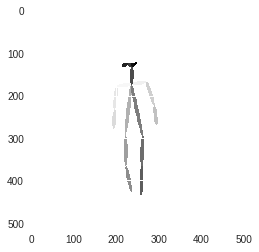

In [27]:
multiplier = get_multiplier(img)
with torch.no_grad():
    paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    
r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
heatmap[:, :, :-1] = r_heatmap
param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
label = get_pose(param, heatmap, paf)

plt.imshow(label)

## make label images for pix2pix

In [13]:
test_img_dir = save_dir.joinpath('test_img')
test_img_dir.mkdir(exist_ok=True)
test_label_dir = save_dir.joinpath('test_label')
test_label_dir.mkdir(exist_ok=True)

for idx in tqdm(range(435, 435+30)):
    img_path = img_dir.joinpath(f'img_{idx:04d}.png')
    img = cv2.imread(str(img_path))
    shape_dst = np.min(img.shape[:2])
    oh = (img.shape[0] - shape_dst) // 2
    ow = (img.shape[1] - shape_dst) // 2

    img = img[oh:oh+shape_dst, ow:ow+shape_dst]
    img = cv2.resize(img, (512, 512))
    multiplier = get_multiplier(img)
    with torch.no_grad():
        paf, heatmap = get_outputs(multiplier, img, model, 'rtpose')
    r_heatmap = np.array([remove_noise(ht)
                      for ht in heatmap.transpose(2, 0, 1)[:-1]])\
                     .transpose(1, 2, 0)
    heatmap[:, :, :-1] = r_heatmap
    param = {'thre1': 0.1, 'thre2': 0.05, 'thre3': 0.5}
    label = get_pose(param, heatmap, paf)
    cv2.imwrite(str(test_img_dir.joinpath(f'img_{idx:04d}.png')), img)
    cv2.imwrite(str(test_label_dir.joinpath(f'label_{idx:04d}.png')), label)
    
torch.cuda.empty_cache()

100%|██████████| 30/30 [03:35<00:00,  7.11s/it]
